In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

# Hands-on Activity 23.2: Maximum Upper Interval

## Objectives

+ Develop intuition about the maximum upper interval acquisition function

## Exploration vs Exploitation

The question is this: "Where should we evaluate the function next if our goal is to maximize it?"
Two possibilities of choosing a point for the next evaluation are:
+ **Exploitation:** We can choose a point $\mathbf{x}$ that *exploits* our current state of knowledge by concentrating on the region where the model thinks the maximum is. In our working example, that would be the point right next to the left most observation.
+ **Exploration:** We can *explore* the regions of maximum predictive uncertainty because there is a high chance that they may hide the maximum of the function. In our working example, this is the region between the two observations on the right.

Generally speaking, it is a very bad idea to focus exclusive on either on exploration or exploitation.
On one hand, if we focus on exploration, then we will at the end recover the true response surface (and as a consequence we will get the correct maximum of the function) but we waste a lot of evaluations on regions that are very unlikely to contain the maximum.
If on the other hand we focus on exploitation, then we will very quickly converge to a local maximum, maybe a good one maybe a bad one, and a lot of the input space will remain unexplored, see the previous hands-on activity.

So, what should a good *information acquisition function* $a_n(\mathbf{x})$ for optimization do?
It should *strike a balance between exploration and exploitation* in a way that provably reveals, in the limit of large number of evaluations, the global maximum of the function.
Are there such information acquisition algorithms? Yes there are.
We are going to explore the first such acquisition function, the maximum upper interval, in this hands-on activity.

Let's reintroduce the same running example as the previous hands-on activity.

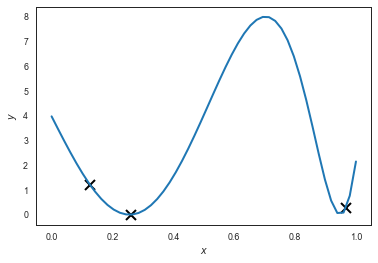

In [3]:
def f(x):
    return 4 * (1. - np.sin(6 * x + 8 * np.exp(6 * x - 7.))) 

np.random.seed(123456) # For reproducibility
n_init = 3
X = np.random.rand(n_init) # In 1D you don't have to use LHS
Y = f(X)
plt.plot(X, Y, 'kx', markersize=10, markeredgewidth=2)
x = np.linspace(0, 1)
plt.plot(x, f(x), linewidth=2)
plt.xlabel('$x$')
plt.ylabel('$y$');

## Maximum upper interval

Just like in the previous hands-on activity, assume that we have made some observations and that we have used them to do Gaussian process regression resulting in the point-predictive distribution:
$$
p(y|\mathbf{x},\mathcal{D}_{n}) = \mathcal{N}\left(y|m_{n}(\mathbf{x}), \sigma^2_{n}(\mathbf{x})\right),
$$
where $m_{n}(\mathbf{x})$ and $\sigma^2_{n}(\mathbf{x})$ are the predictive mean and variance respectively.
Here is the code for this:

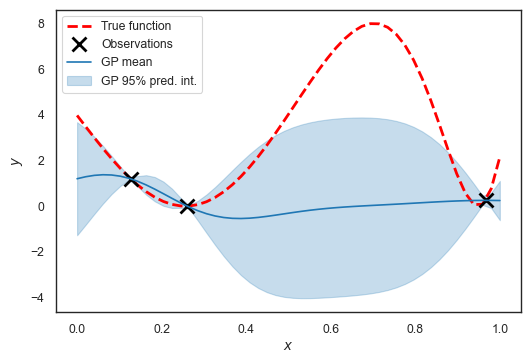

In [4]:
import GPy
# The kernel we use
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
# Assuming that we know there is no measurement noise:
gpr.likelihood.variance.constrain_fixed(1e-16)
# You can evaluate the predictive distribution anywhere:
m, sigma2 = gpr.predict(x[:, None])
# And you can visualize the results as follows
# Standard deviation
sigma = np.sqrt(sigma2)
# Lower quantile
l = m - 1.96 * sigma
u = m + 1.96 * sigma
fig, ax = plt.subplots(dpi=100)
plt.plot(x, f(x), 'r--', linewidth=2, label='True function')
ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='Observations')
ax.plot(x, m, label='GP mean')
ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25,
                label='GP 95% pred. int.')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

The maximum upper interval is defined to be:
$$
a_n(\mathbf{x}) = \mu_n(\mathbf{x}) + \psi \sigma_n(\mathbf{x}),
$$
for some $\psi \ge 0$.
Note that here we are using the predictive mean and variance.
The parametr $\psi$ controls how much emphasis you put on exploitation and exploration.
The choice $\psi = 0$ is full-on exploitation. You are just looking at the predictive mean.
The greater $\psi$ is, the more emphasis you put on the predictive standard deviation, i.e., the more you try to explore.
Okay, so the information acquisition function depends only on the posterior mean, variance, and that parameter $\psi$.
Let's implement it:

In [5]:
def mui(m, sigma, ymax, psi=1.96):
    return m + psi * sigma

Now let's write code that carries out Bayesian global optimization for using the maximum upper interval as the information acquisition function.

In [6]:
def plot_mui(psi=0.):
    fig, ax = plt.subplots(dpi=100)
    ax.set_title('$\psi={0:1.2f}$'.format(psi))
    ax.plot(X, Y, 'kx', markersize=10, markeredgewidth=2, label='Observations')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.plot(x, m, label='GP mean')
    ax.fill_between(x, l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25,
                    label='GP 95% pred. int.')
    ax.plot(x, f(x), 'r--', label='True function')
    plt.legend(loc='best')
    af_values = mui(m, sigma, Y.max(), psi)
    next_id = np.argmax(af_values)
    next_x = x[next_id]
    af_max = af_values[next_id]
    ax2 = ax.twinx()
    ax2.plot(x, af_values, color=sns.color_palette()[1])
    ax2.set_ylabel('Maximum Upper Interval', color=sns.color_palette()[1])
    plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
    ax2.plot(next_x * np.ones(100), np.linspace(0, af_max, 100), color=sns.color_palette()[1],
         linewidth=1)

from ipywidgets import interactive, interact_manual
    
interactive(plot_mui, psi=(0., 4., 0.001))

interactive(children=(FloatSlider(value=0.0, description='psi', max=4.0, step=0.001), Output()), _dom_classes=…

### Questions
+ Experiment with different values of $\psi$.
+ When do you get exploration?
+ When do you get exploitation?

## Bayesian global optimization with the maximum upper interval

Let's now run the Bayesian global optimization algorithm using the maximum upper interval as the information acquisition function.
For convenience, I have written the following generic code for you:

In [7]:
def maximize(f, gpr, X_design, alpha, psi=0., max_it=6):
    """
    Optimize f using a limited number of evaluations.
    
    :param f:        The function to optimize.
    :param gpr:      A Gaussian process model to use for representing our state of knowldege.
    :param X_design: The set of candidate points for identifying the maximum.
    :param alpha:    The acquisition function.
    :param psi:      The parameter value for the acquisition function (not used for EI).
    :param max_it:   The maximum number of iterations.
    """
    af_all = []
    for count in range(max_it):
        m, sigma2 = gpr.predict(X_design)
        sigma = np.sqrt(sigma2)
        l = m - 1.96 * sigma
        u = m + 1.96 * sigma
        af_values = alpha(m, sigma, gpr.Y.max(), psi=psi)
        i = np.argmax(af_values)
        X = np.vstack([gpr.X, X_design[i:(i+1), :]])
        y = np.vstack([gpr.Y, [f(X_design[i, :])]])
        gpr.set_XY(X, y)
        # Uncomment the following to optimize the hyper-parameters
        # gpr.optimize()
        af_all.append(af_values[i])
        fig, ax = plt.subplots(dpi=100)
        ax.plot(gpr.X, gpr.Y, 'kx', markersize=10, markeredgewidth=2)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
        ax.plot(x, m)
        ax.fill_between(X_design.flatten(), l.flatten(), u.flatten(), color=sns.color_palette()[0], alpha=0.25)
        ax2 = ax.twinx()
        ax2.plot(X_design, af_values, color=sns.color_palette()[1])
        plt.setp(ax2.get_yticklabels(), color=sns.color_palette()[1])
        ax2.set_ylabel('acquisition function', color=sns.color_palette()[1])
        ax2.plot(X_design[i, :] * np.ones(100), np.linspace(0, af_values[i], 100), color=sns.color_palette()[1],
                 linewidth=1)
    return af_all

The code accepts the information acquisition function as an input.
Here is how you can use it:

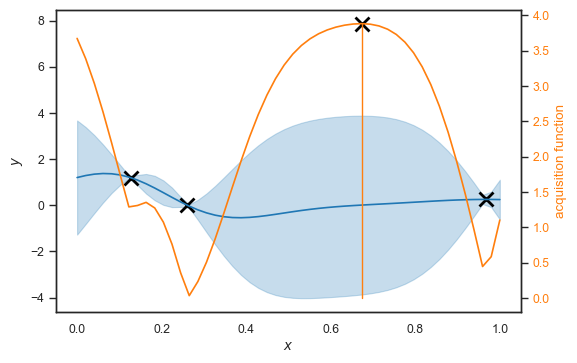

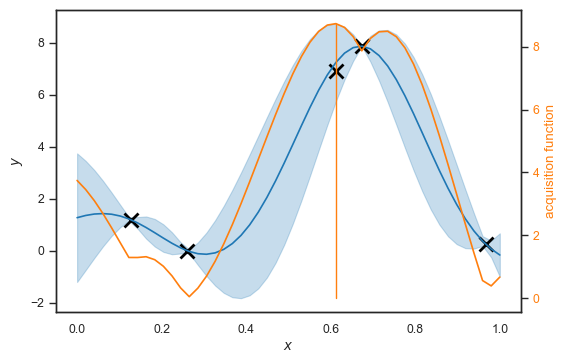

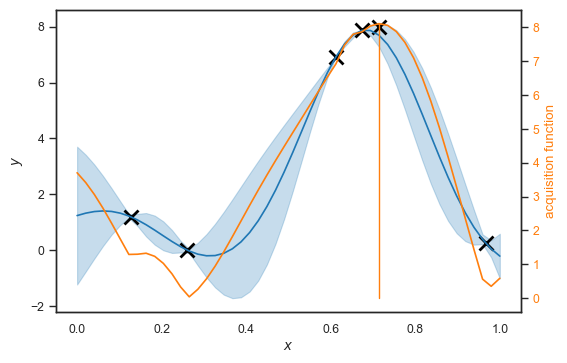

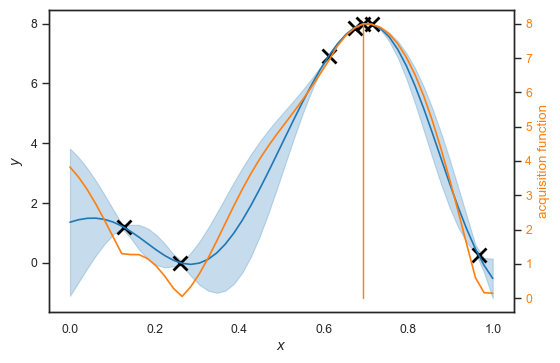

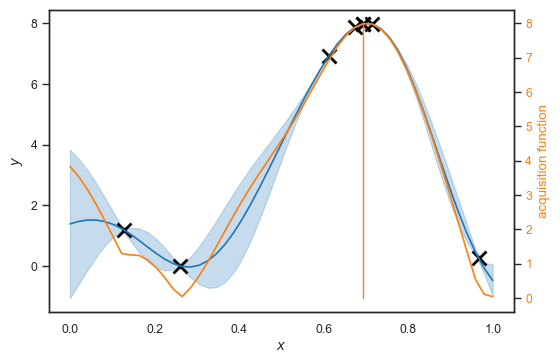

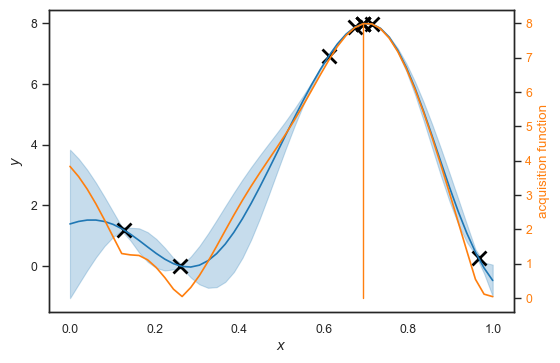

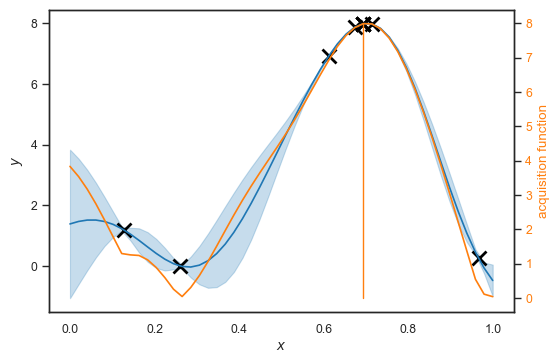

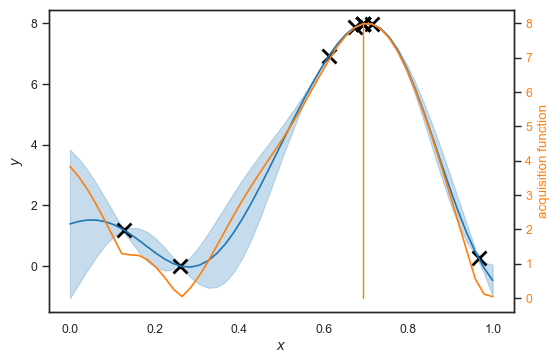

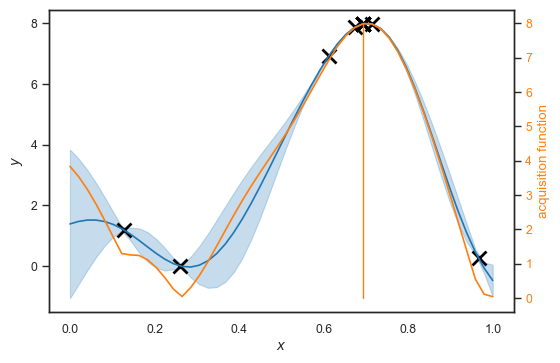

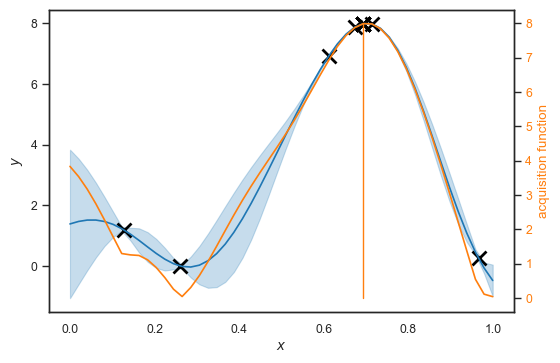

In [13]:
# Prepare the initial statistical model
k = GPy.kern.RBF(1, lengthscale=0.15, variance=4.)
gpr = GPy.models.GPRegression(X[:, None], Y[:, None], k)
gpr.likelihood.variance.constrain_fixed(1e-16)

# Run the algorithm
af_all = maximize(f, gpr, x[:, None], alpha=mui, psi=1.96, max_it=10)

### Questions
+ Repeat the main algorithm using MUI for a $\psi$ that exploits. Does the method converge?
+ Repeat the main algorithm using MUI for a $\psi$ that explores. Does the method converge?